In [1]:
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
from skimage.io import imread 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation  
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.optimizers import Adam,SGD
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
def plot_history(history, fn,save_path):
    # Loss Curves
    plt.figure()
    plt.plot(history.history['loss'],'r',linewidth=1.0)
    plt.plot(history.history['val_loss'],'b',linewidth=1.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
    plt.xlabel('Epochs ',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.title('Loss Curves',fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    pt = 'loss_'+fn+'.png'
    plt.savefig(os.path.join(save_path,pt))
    # Accuracy Curves
    plt.figure()
    plt.plot(history.history['acc'],'r',linewidth=1.0)
    plt.plot(history.history['val_acc'],'b',linewidth=1.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=10)
    plt.xlabel('Epochs ',fontsize=10)
    plt.ylabel('Accuracy',fontsize=10)
    plt.title('Accuracy Curves',fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    pt = 'acc_'+fn+'.png'
    plt.savefig(os.path.join(save_path,pt))

In [3]:
def createModel1(input_shape,nClasses):
    model = Sequential()

#    model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
#    model.add(BatchNormalization(axis=-1))
#    model.add(Activation('relu'))
#    model.add(Dropout(0.5))
    
    model.add(Conv2D(8, (5, 5), padding='same',input_shape=input_shape))
    #model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4,4)))
    model.add(Dropout(0.6))
    
#    model.add(Conv2D(64,(3, 3)))
#    model.add(BatchNormalization(axis=-1))
#    model.add(Activation('relu'))
#    model.add(Dropout(0.5))
    
    model.add(Conv2D(16, (5, 5), padding='same'))
    #model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4,4)))
    model.add(Dropout(0.6))
    
    model.add(Conv2D(32, (5,5), padding='same'))
    #model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4,4)))
    model.add(Dropout(0.6))

    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(512))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    model.add(Dense(nClasses))

#     # Fully connected layer
#     model.add(Dense(128))
#     #model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.6))
#     model.add(Dense(nClasses))
    
    model.add(Activation('softmax'))
#     sgd = SGD(lr=0.01, momentum=0.9)
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def convertlabel(label):
    if label[0] == 0 and label[1] == 0 and label[2] == 0:
            return(0)

    elif label[0] == 0 and label[1] == 0 and label[2] == 1:
            return(1)
    elif label[0] == 0 and label[1] == 1 and label[2] == 0:
            return(2)
    elif label[0] == 0 and label[1] == 1 and label[2] == 1:
            return(3)
    elif label[0] == 1 and label[1] == 0 and label[2] == 0:
            return(4)
    elif label[0] == 1 and label[1] == 0 and label[2] == 1:
            return(5)
    elif label[0] == 1 and label[1] == 1 and label[2] == 0:
            return(6)
    elif label[0] == 1 and label[1] == 1 and label[2] == 1:
            return(7)

In [5]:
def get_batch(batch_size,X_train,Y_train,imgw, imgh):
    rindx = np.random.randint(0,X_train.shape[0],size=batch_size)
    image_train = np.zeros([batch_size,imgw, imgh],dtype=np.float32)
    label_train = np.zeros((batch_size))
    cnt = 0
    for k in rindx:
        image_train[cnt,:,:] = X_train[k,:,:]
        label_train[cnt] = Y_train[k]
    return image_train, label_train  

In [6]:
def plot_result(evaldata,epochs, met,fname):
    plt.plot(range(len(evaldata)),evaldata)
    plt.xlabel('epochs')
    plt.ylabel(met)
    ttl = 'The '+ met +' for '+ fname
    pn = '\plots\ '+ met +' _ '+ fname + '.png'
    plt.title(ttl)
    plt.savefig(pn)
    plt.show()

In [7]:
def reshape_data(train_data, trainLable_cnn1,trainLable_cnn2, trainLable_cnn3):
    nclass = 2
    train_data = train_data.reshape((train_data.shape[0], image_rows, image_cols, channel))
    trainLable_cnn1 = np_utils.to_categorical(trainLable_cnn1, nclass)
    trainLable_cnn2 = np_utils.to_categorical(trainLable_cnn2, nclass)
    trainLable_cnn3 = np_utils.to_categorical(trainLable_cnn3, nclass)
    return train_data,trainLable_cnn1,trainLable_cnn2,trainLable_cnn3

In [8]:
def convert_to_binary(Y_test):
    y_pred = []
    for i in range(len(Y_test)):
        if Y_test[i,0]==1.0:
            y_pred.append(0)  
        elif Y_test[i,1]==1.0:
            y_pred.append(1)
    y_pred = np.array(y_pred)   
    return(y_pred)

In [9]:
def report_evalmetric(y_true,y_pred,save_path,fn):
    target_names = ["Clean", "noisy"]
    y_true = convert_to_binary(y_true)
    # Compute a confusion matrix and a normalised confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Confusion Matrix')
    print(cm_normalised)
    
    # Print a classification report, including precision, recall, and f1-score.
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=target_names)) 

    pt = 'y_pred'+fn +'.txt'
    np.savetxt(os.path.join(save_path,pt), y_pred)

    # Plot a confusion matrix graphically 
    sns.set(font_scale=4.5) 
    fig, ax = plt.subplots(figsize=(30,20))
    ax = sns.heatmap(cm, annot=True, linewidths=2.5, square=True, linecolor="Green", 
                    cmap="Greens", yticklabels=target_names, xticklabels=target_names, vmin=0, vmax=900, 
                    fmt="d", annot_kws={"size": 50})
    ax.set(xlabel='Predicted label', ylabel='True label')
    pt = 'confmat_'+fn +'.png'
    fig.savefig(os.path.join(save_path,pt))

In [10]:
def find_numposneg(genlabels):
    pos_indx = [i for i, j in enumerate(genlabels) if j ==1]
    neg_indx = [i for i, j in enumerate(genlabels) if j ==0]
    return(len(pos_indx),len(neg_indx))

In [11]:
image_rows = 384
image_cols = 384
channel = 1
nclass = 2
PS = 32
augbased = 0
epochs = 100
batch_size = 32
logs_path = "D:\Chirag B\ComputerVision\IVUSNoiseClassification\CNN3-Results\Plots"
output = 'D:\Chirag B\ComputerVision\IVUSNoiseClassification\CNN3-Results\Results'
DataAug = True
###################################### Read the data and the label
train_data = np.load('D:\Chirag B\ComputerVision\Codes\TrainData.npy')
test_data = np.load('D:\Chirag B\ComputerVision\Codes\TestData.npy')
trainLable_cnn1 = np.load('D:\Chirag B\ComputerVision\Codes\Train_label_cn1.npy')
trainLable_cnn2 = np.load('D:\Chirag B\ComputerVision\Codes\Train_label_cn2.npy')
trainLable_cnn3 = np.load('D:\Chirag B\ComputerVision\Codes\Train_label_cn3.npy')
testLable_cnn1 = np.load('D:\Chirag B\ComputerVision\Codes\Test_label_cn1.npy')
testLable_cnn2 = np.load('D:\Chirag B\ComputerVision\Codes\Test_label_cn2.npy')
testLable_cnn3 = np.load('D:\Chirag B\ComputerVision\Codes\Test_label_cn3.npy')
print('Train Data shape and Test Data shape is:', train_data.shape,test_data.shape)
trp_cnn1,trn_cnn1 = find_numposneg(trainLable_cnn1)
trp_cnn2,trn_cnn2 = find_numposneg(trainLable_cnn2)
trp_cnn3,trn_cnn3 = find_numposneg(trainLable_cnn3)
tep_cnn1,ten_cnn1 = find_numposneg(testLable_cnn1)
tep_cnn2,ten_cnn2 = find_numposneg(testLable_cnn2)
tep_cnn3,ten_cnn3 = find_numposneg(testLable_cnn3)
print('The number of pos and neg samples in training data of CNN1, CNN2 and CNN3 are:',trp_cnn1,trn_cnn1,trp_cnn2, trn_cnn2, trp_cnn3, trn_cnn3)
print('The number of pos and neg samples in testing data of CNN1, CNN2 and CNN3 are:',tep_cnn1,ten_cnn1,tep_cnn2, ten_cnn2, tep_cnn3, ten_cnn3)


Train Data shape and Test Data shape is: (109, 384, 384) (326, 384, 384)
The number of pos and neg samples in training data of CNN1, CNN2 and CNN3 are: 11 98 51 58 42 67
The number of pos and neg samples in testing data of CNN1, CNN2 and CNN3 are: 58 268 182 144 206 120


In [12]:
train_data = train_data.reshape((train_data.shape[0], image_rows, image_cols, channel))
test_data = test_data.reshape((test_data.shape[0], image_rows, image_cols, channel))
train_data= train_data.astype(np.float32) / train_data.max()
test_data = test_data.astype(np.float32) / test_data.max()
trainLable_cnn1 = np_utils.to_categorical(trainLable_cnn1, nclass)
trainLable_cnn2 = np_utils.to_categorical(trainLable_cnn2, nclass)
trainLable_cnn3 = np_utils.to_categorical(trainLable_cnn3, nclass)
testLable_cnn1 = np_utils.to_categorical(testLable_cnn1, nclass)
testLable_cnn2 = np_utils.to_categorical(testLable_cnn2, nclass)
testLable_cnn3 = np_utils.to_categorical(testLable_cnn3, nclass)
###################################### Build Networks for classification
inpshape=(image_rows, image_cols,channel)
cnn1 = createModel1(inpshape,nclass)
cnn2 = createModel1(inpshape,nclass)
cnn3 = createModel1(inpshape,nclass)
cnn1.summary()
# plot_model(cnn1, show_shapes=True,to_file=os.path.join(output, 'cnn1.png'))
# plot_model(cnn2, show_shapes=True,to_file=os.path.join(output, 'cnn2.png'))
# plot_model(cnn3, show_shapes=True,to_file=os.path.join(output, 'cnn3.png'))
print('_________________________ CNNs are Built! __________________________________________')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 384, 384, 8)       208       
_________________________________________________________________
activation_1 (Activation)    (None, 384, 384, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 96, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 16)        3216      
_________________________________________________________________
activation_2 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
__________

With out Data Augmentation
######################### CNN1 Training ##############################
Train on 109 samples, validate on 326 samples
Epoch 1/100
109/109 [==============================] - 4s 35ms/step - loss: 1.1540 - acc: 0.6239 - val_loss: 0.5815 - val_acc: 0.8221
Epoch 2/100
109/109 [==============================] - 0s 4ms/step - loss: 0.7469 - acc: 0.8257 - val_loss: 0.5460 - val_acc: 0.8221
Epoch 3/100
109/109 [==============================] - 0s 4ms/step - loss: 0.5870 - acc: 0.9083 - val_loss: 0.5432 - val_acc: 0.8221
Epoch 4/100
109/109 [==============================] - 0s 5ms/step - loss: 0.3838 - acc: 0.8991 - val_loss: 0.5520 - val_acc: 0.8221
Epoch 5/100
109/109 [==============================] - 0s 5ms/step - loss: 0.6001 - acc: 0.8899 - val_loss: 0.5703 - val_acc: 0.8221
Epoch 6/100
109/109 [==============================] - 0s 4ms/step - loss: 0.5957 - acc: 0.8899 - val_loss: 0.5944 - val_acc: 0.8221
Epoch 7/100
109/109 [==============================] - 0s

109/109 [==============================] - 0s 4ms/step - loss: 0.2906 - acc: 0.8991 - val_loss: 0.6491 - val_acc: 0.8221
Epoch 62/100
109/109 [==============================] - 0s 5ms/step - loss: 0.3361 - acc: 0.8899 - val_loss: 0.6509 - val_acc: 0.8221
Epoch 63/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2543 - acc: 0.9174 - val_loss: 0.6519 - val_acc: 0.8190
Epoch 64/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2768 - acc: 0.8899 - val_loss: 0.6506 - val_acc: 0.8221
Epoch 65/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2722 - acc: 0.8991 - val_loss: 0.6496 - val_acc: 0.8221
Epoch 66/100
109/109 [==============================] - 1s 5ms/step - loss: 0.2781 - acc: 0.9083 - val_loss: 0.6485 - val_acc: 0.8221
Epoch 67/100
109/109 [==============================] - 0s 5ms/step - loss: 0.2678 - acc: 0.8991 - val_loss: 0.6479 - val_acc: 0.8221
Epoch 68/100
109/109 [==============================] - 0s 5ms/step - loss:

109/109 [==============================] - 0s 4ms/step - loss: 0.7498 - acc: 0.5138 - val_loss: 0.6905 - val_acc: 0.6258
Epoch 22/100
109/109 [==============================] - 0s 4ms/step - loss: 0.6732 - acc: 0.5780 - val_loss: 0.6905 - val_acc: 0.5890
Epoch 23/100
109/109 [==============================] - 0s 4ms/step - loss: 0.7190 - acc: 0.5229 - val_loss: 0.6903 - val_acc: 0.6258
Epoch 24/100
109/109 [==============================] - 0s 4ms/step - loss: 0.6914 - acc: 0.5229 - val_loss: 0.6902 - val_acc: 0.6258
Epoch 25/100
109/109 [==============================] - 0s 4ms/step - loss: 0.6812 - acc: 0.5963 - val_loss: 0.6901 - val_acc: 0.6380
Epoch 26/100
109/109 [==============================] - 0s 5ms/step - loss: 0.7381 - acc: 0.5138 - val_loss: 0.6901 - val_acc: 0.6442
Epoch 27/100
109/109 [==============================] - 0s 5ms/step - loss: 0.6982 - acc: 0.4862 - val_loss: 0.6902 - val_acc: 0.6411
Epoch 28/100
109/109 [==============================] - 0s 5ms/step - loss:

109/109 [==============================] - 0s 4ms/step - loss: 0.6547 - acc: 0.6330 - val_loss: 0.6851 - val_acc: 0.6718
Epoch 83/100
109/109 [==============================] - 0s 5ms/step - loss: 0.6531 - acc: 0.6514 - val_loss: 0.6850 - val_acc: 0.6718
Epoch 84/100
109/109 [==============================] - 0s 4ms/step - loss: 0.6583 - acc: 0.5872 - val_loss: 0.6847 - val_acc: 0.6810
Epoch 85/100
109/109 [==============================] - 0s 4ms/step - loss: 0.6409 - acc: 0.6514 - val_loss: 0.6845 - val_acc: 0.6748
Epoch 86/100
109/109 [==============================] - 0s 4ms/step - loss: 0.6396 - acc: 0.6789 - val_loss: 0.6842 - val_acc: 0.6779
Epoch 87/100
109/109 [==============================] - 0s 4ms/step - loss: 0.6032 - acc: 0.7523 - val_loss: 0.6839 - val_acc: 0.6779
Epoch 88/100
109/109 [==============================] - 0s 5ms/step - loss: 0.6692 - acc: 0.5596 - val_loss: 0.6836 - val_acc: 0.6871
Epoch 89/100
109/109 [==============================] - 0s 4ms/step - loss:

109/109 [==============================] - 0s 5ms/step - loss: 0.6821 - acc: 0.5780 - val_loss: 0.6969 - val_acc: 0.3681
Epoch 43/100
109/109 [==============================] - 0s 5ms/step - loss: 0.6948 - acc: 0.6147 - val_loss: 0.6969 - val_acc: 0.3681
Epoch 44/100
109/109 [==============================] - 1s 5ms/step - loss: 0.7200 - acc: 0.6330 - val_loss: 0.6968 - val_acc: 0.3681
Epoch 45/100
109/109 [==============================] - 0s 5ms/step - loss: 0.6564 - acc: 0.6606 - val_loss: 0.6968 - val_acc: 0.3681
Epoch 46/100
109/109 [==============================] - 0s 5ms/step - loss: 0.7044 - acc: 0.5321 - val_loss: 0.6967 - val_acc: 0.3681
Epoch 47/100
109/109 [==============================] - 0s 5ms/step - loss: 0.6351 - acc: 0.6147 - val_loss: 0.6964 - val_acc: 0.3712
Epoch 48/100
109/109 [==============================] - 0s 5ms/step - loss: 0.6467 - acc: 0.6330 - val_loss: 0.6960 - val_acc: 0.3773
Epoch 49/100
109/109 [==============================] - 0s 5ms/step - loss:

Confusion Matrix
[[0.34722222 0.65277778]
 [0.04945055 0.95054945]]
Classification Report
              precision    recall  f1-score   support

       Clean       0.85      0.35      0.49       144
       noisy       0.65      0.95      0.77       182

   micro avg       0.68      0.68      0.68       326
   macro avg       0.75      0.65      0.63       326
weighted avg       0.74      0.68      0.65       326

Confusion Matrix
[[1. 0.]
 [1. 0.]]
Classification Report
              precision    recall  f1-score   support

       Clean       0.37      1.00      0.54       120
       noisy       0.00      0.00      0.00       206

   micro avg       0.37      0.37      0.37       326
   macro avg       0.18      0.50      0.27       326
weighted avg       0.14      0.37      0.20       326



C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test loss and accuracy for CNN1 is: 0.6427381276353005 0.7852760736196319
Test loss and accuracy for CNN2 is: 0.6820901069173052 0.6840490793889286
Test loss and accuracy for CNN3 is: 0.6962681602846625 0.36809815960062064


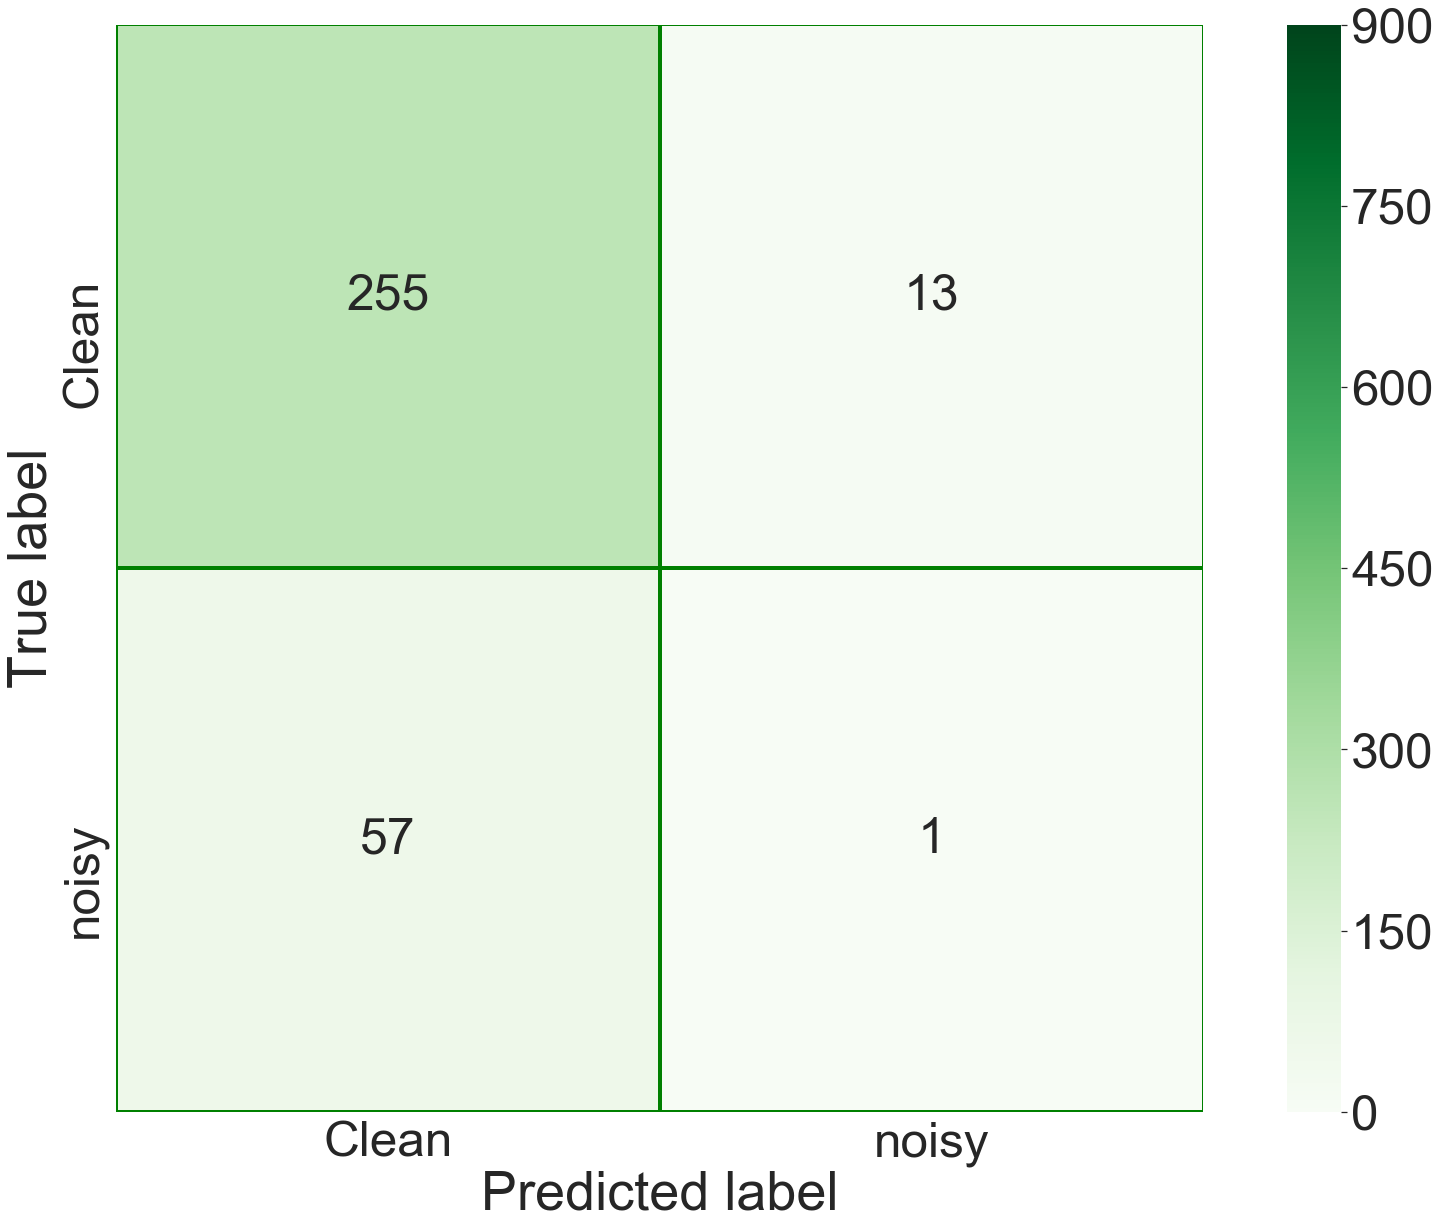

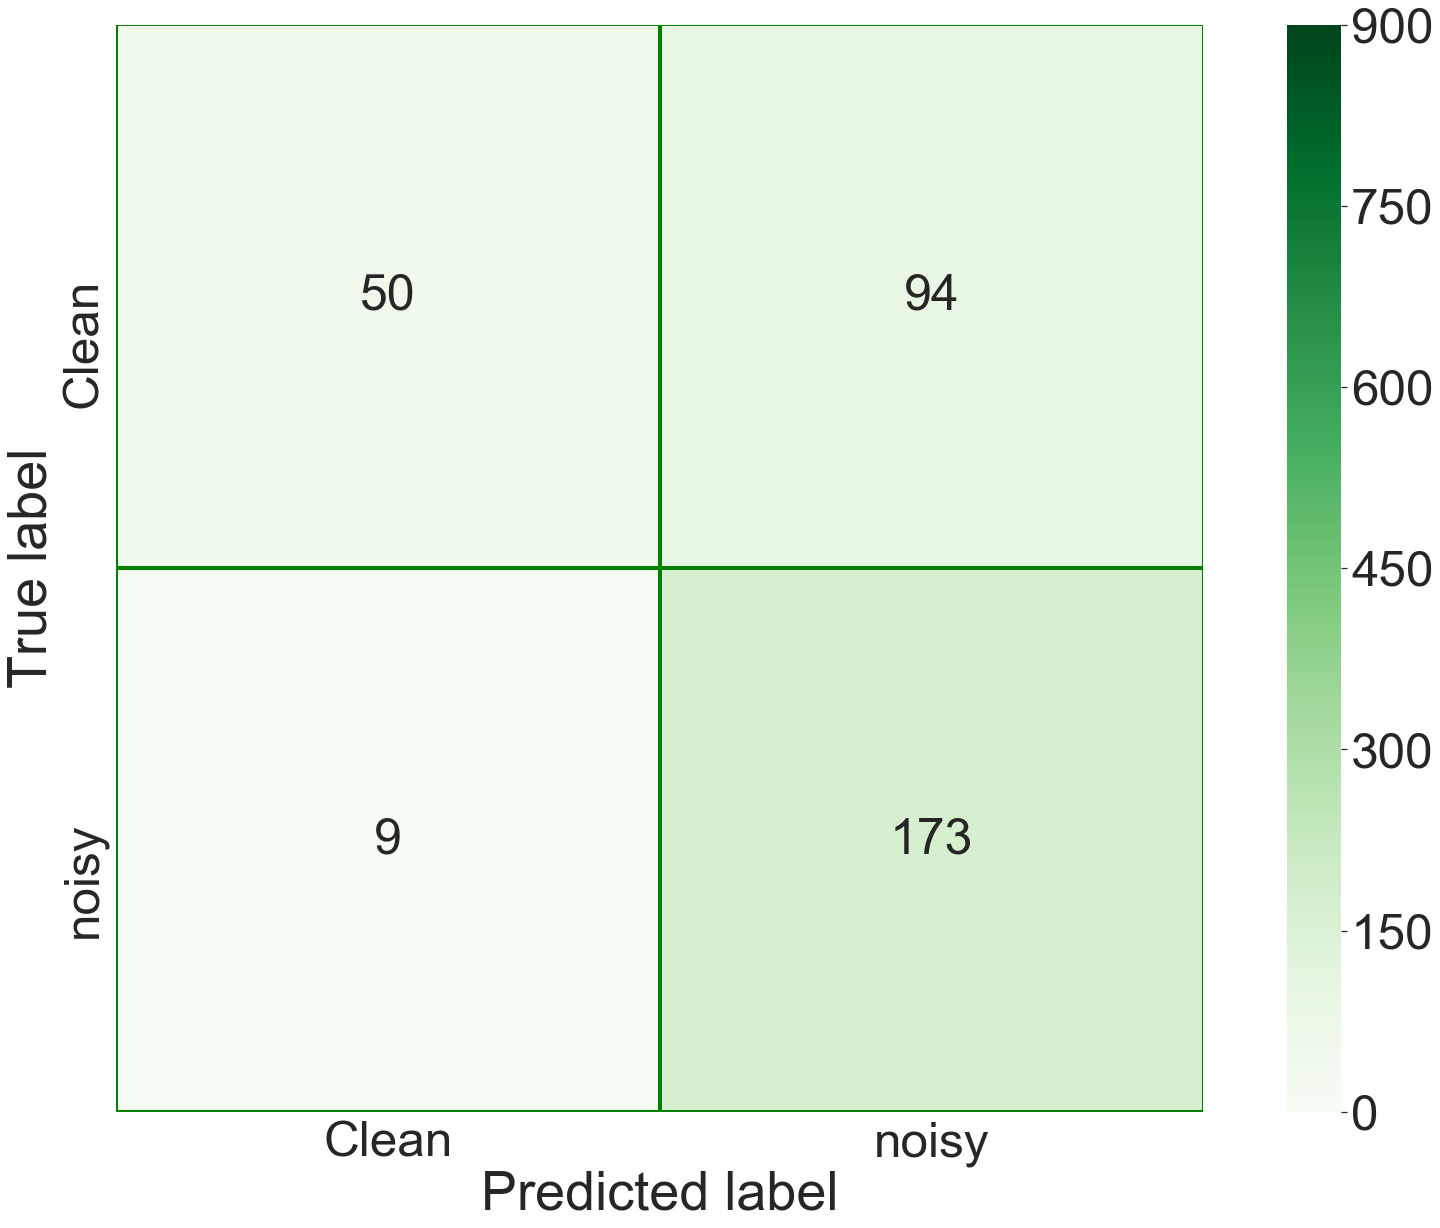

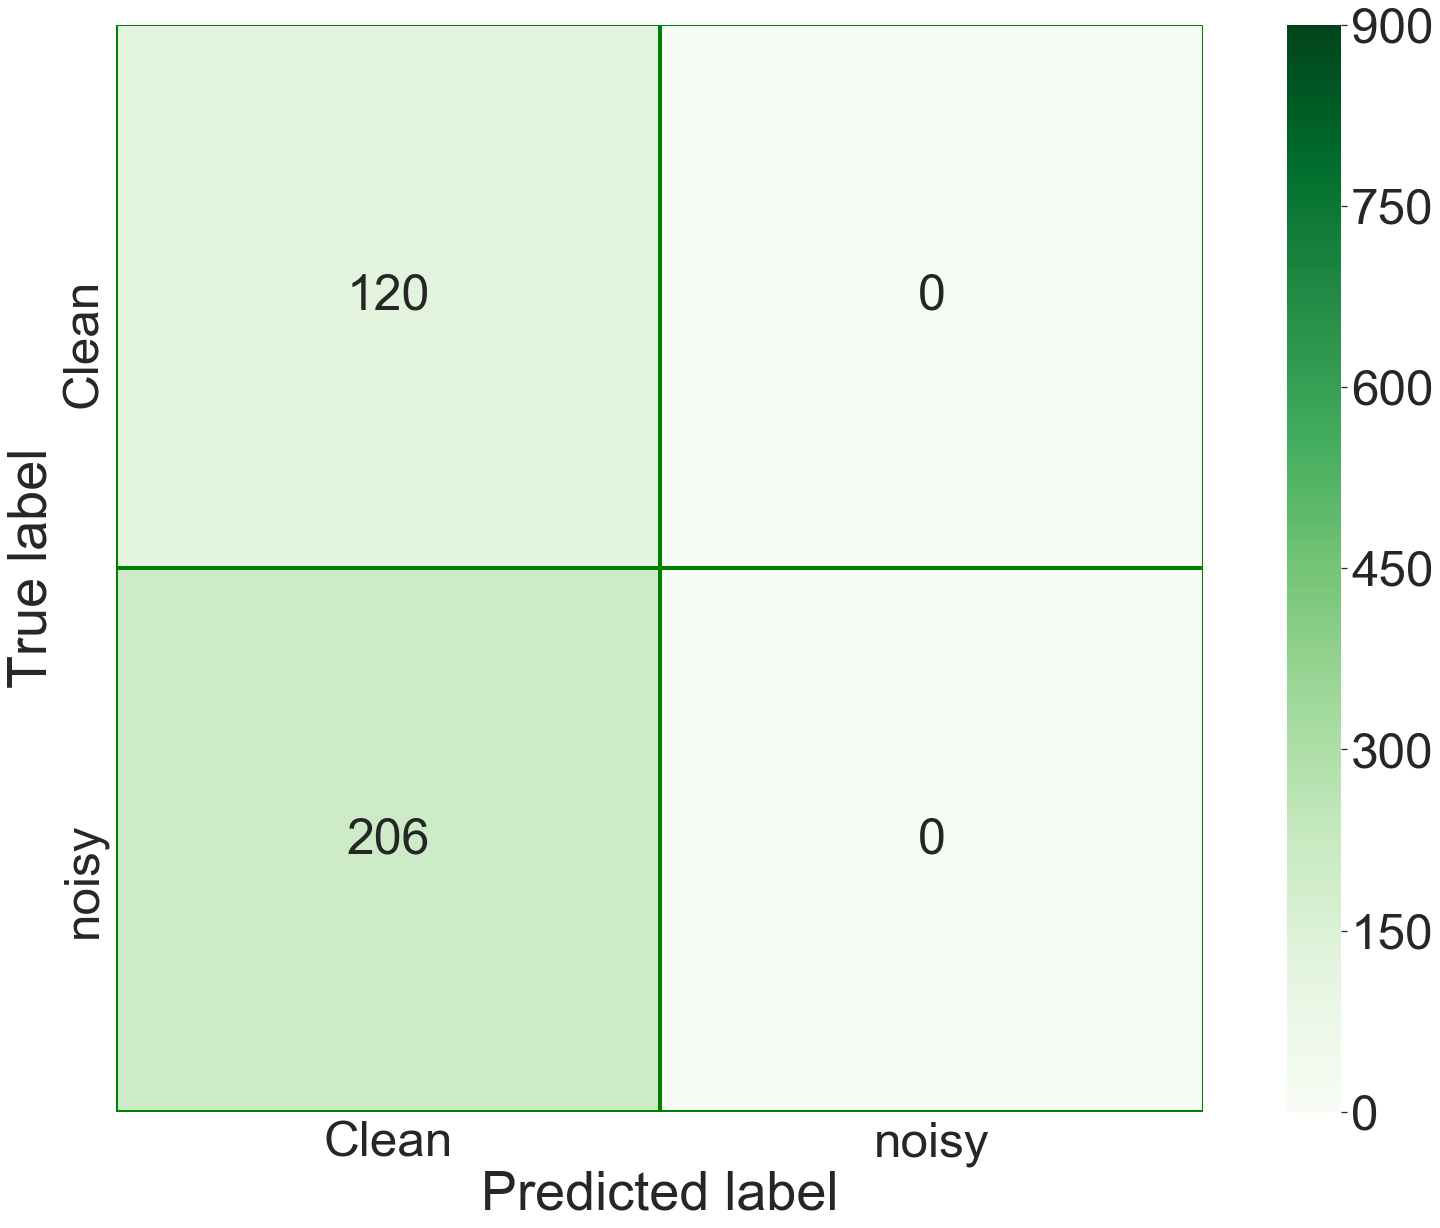

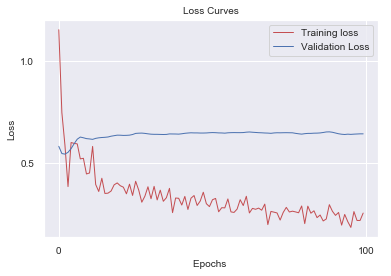

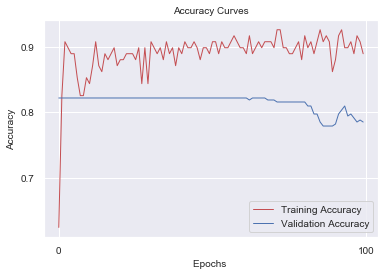

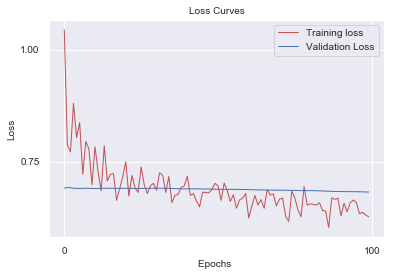

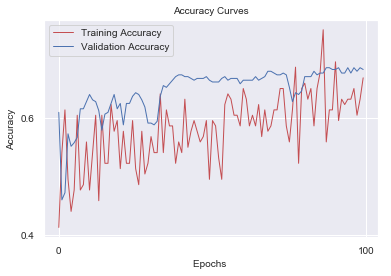

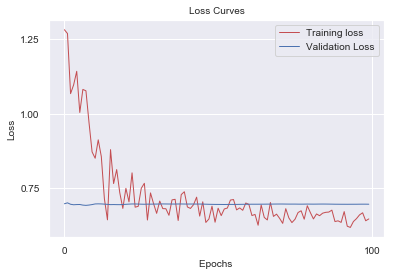

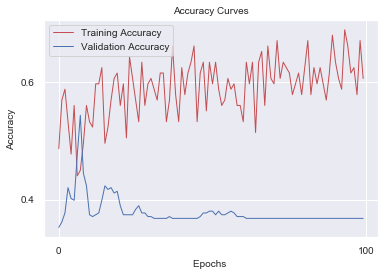

In [13]:
# if DataAug ==  False:
print('With out Data Augmentation')
## Training the models
print('######################### CNN1 Training ##############################')
history_cnn1 = cnn1.fit(train_data, trainLable_cnn1, batch_size=batch_size, epochs=epochs, verbose=1, 
               validation_data=(test_data, testLable_cnn1), shuffle=True, class_weight = 'auto')
print('######################### CNN2 Training ##############################')
history_cnn2 = cnn2.fit(train_data, trainLable_cnn2, batch_size=batch_size, epochs=epochs, verbose=1, 
               validation_data=(test_data, testLable_cnn2), shuffle=True, class_weight = 'auto')
print('######################### CNN3 Training ##############################')
history_cnn3 = cnn3.fit(train_data, trainLable_cnn3, batch_size=batch_size, epochs=epochs, verbose=1, 
               validation_data=(test_data, testLable_cnn3), shuffle=True, class_weight = 'auto')
## Evaluate themodesl
loss_cnn1, acc_cnn1 = cnn1.evaluate(test_data, testLable_cnn1, verbose=0,batch_size=batch_size)              
loss_cnn2, acc_cnn2 = cnn2.evaluate(test_data, testLable_cnn2, verbose=0,batch_size=batch_size)  
loss_cnn3, acc_cnn3 = cnn3.evaluate(test_data, testLable_cnn3, verbose=0,batch_size=batch_size)

y_pred_cnn1 = cnn1.predict_classes(test_data)
y_pred_cnn2 = cnn2.predict_classes(test_data)
y_pred_cnn3 = cnn3.predict_classes(test_data)

skaccuracy1 = accuracy_score(convert_to_binary(testLable_cnn1), y_pred_cnn1)
skaccuracy2 = accuracy_score(convert_to_binary(testLable_cnn2), y_pred_cnn2)
skaccuracy3 = accuracy_score(convert_to_binary(testLable_cnn3), y_pred_cnn3)
print('Accuracy for CNN1, CNN2 and CNN3 are:',skaccuracy1,skaccuracy2,skaccuracy3)

report_evalmetric(testLable_cnn1,y_pred_cnn1,output, 'cnn1')
report_evalmetric(testLable_cnn2,y_pred_cnn2,output, 'cnn2')
report_evalmetric(testLable_cnn3,y_pred_cnn3,output, 'cnn3')

print('Test loss and accuracy for CNN1 is:',loss_cnn1, acc_cnn1)
print('Test loss and accuracy for CNN2 is:',loss_cnn2, acc_cnn2)
print('Test loss and accuracy for CNN3 is:',loss_cnn3, acc_cnn3)

plot_history(history_cnn1,'cnn1', output)
plot_history(history_cnn2,'cnn2', output)
plot_history(history_cnn3,'cnn3', output)
# elif DataAug == True:
#     print('With Data Augmentation')
#     datagen = ImageDataGenerator(
#     rotation_range=180,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#         fill_mode='nearest')
#     print('############################ CNN1 Training ##################')
#     history_cnn1 = cnn1.fit_generator(datagen.flow(train_data, trainLable_cnn1, batch_size=batch_size),
#                               steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
#                               epochs=epochs,
#                               validation_data=(test_data, testLable_cnn1),
#                               workers=4, class_weight = 'auto')
#     print('############################ CNN2 Training ###################')
#     history_cnn2 = cnn2.fit_generator(datagen.flow(train_data, trainLable_cnn2, batch_size=batch_size),
#                               steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
#                               epochs=epochs,
#                               validation_data=(test_data, testLable_cnn2),
#                               workers=4, class_weight = 'auto')
#     print('############################ CNN3 Training ####################')
#     history_cnn3 = cnn3.fit_generator(datagen.flow(train_data, trainLable_cnn3, batch_size=batch_size),
#                               steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
#                               epochs=epochs,
#                               validation_data=(test_data, testLable_cnn3),
#                               workers=4, class_weight = 'auto') 

Accuracy for CNN1, CNN2 and CNN3 are: 0.7852760736196319 0.6840490797546013 0.36809815950920244
Confusion Matrix
[[0.95149254 0.04850746]
 [0.98275862 0.01724138]]
Classification Report
              precision    recall  f1-score   support

       Clean       0.82      0.95      0.88       268
       noisy       0.07      0.02      0.03        58

   micro avg       0.79      0.79      0.79       326
   macro avg       0.44      0.48      0.45       326
weighted avg       0.68      0.79      0.73       326

Confusion Matrix
[[0.34722222 0.65277778]
 [0.04945055 0.95054945]]
Classification Report
              precision    recall  f1-score   support

       Clean       0.85      0.35      0.49       144
       noisy       0.65      0.95      0.77       182

   micro avg       0.68      0.68      0.68       326
   macro avg       0.75      0.65      0.63       326
weighted avg       0.74      0.68      0.65       326

Confusion Matrix
[[1. 0.]
 [1. 0.]]
Classification Report
            

C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\chira\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test loss and accuracy for CNN1 is: 0.6427381276353005 0.7852760736196319
Test loss and accuracy for CNN2 is: 0.6820901069173052 0.6840490793889286
Test loss and accuracy for CNN3 is: 0.6962681602846625 0.36809815960062064


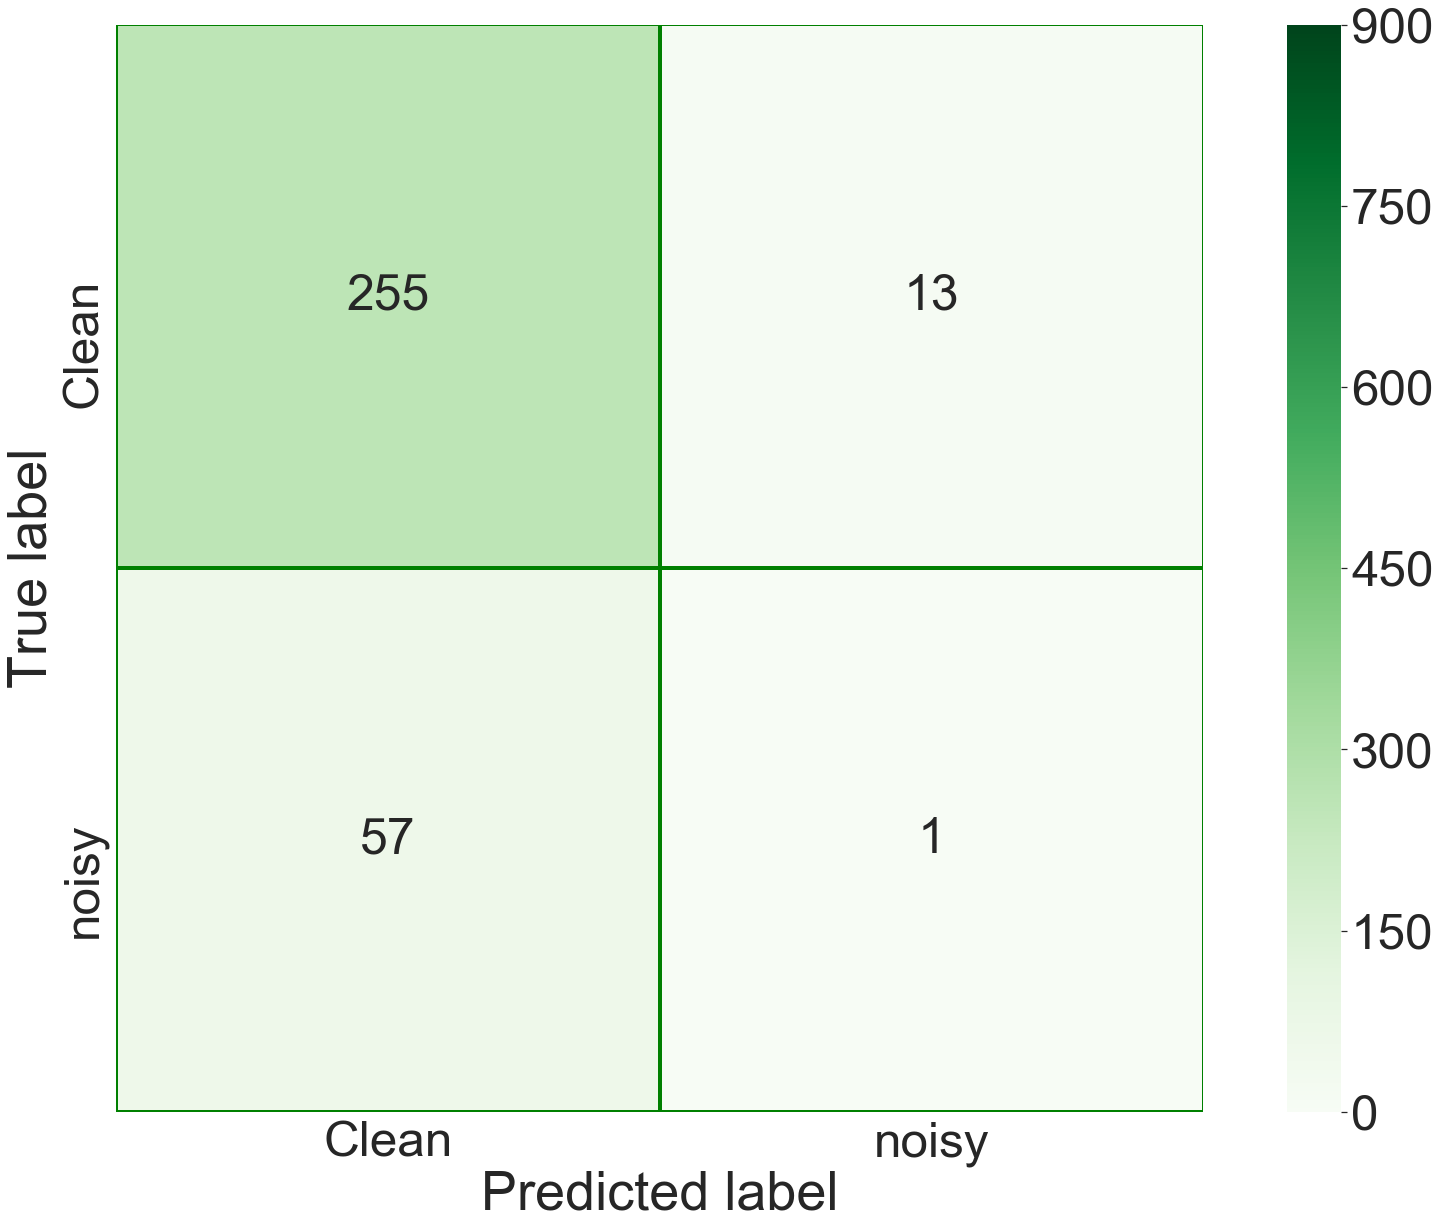

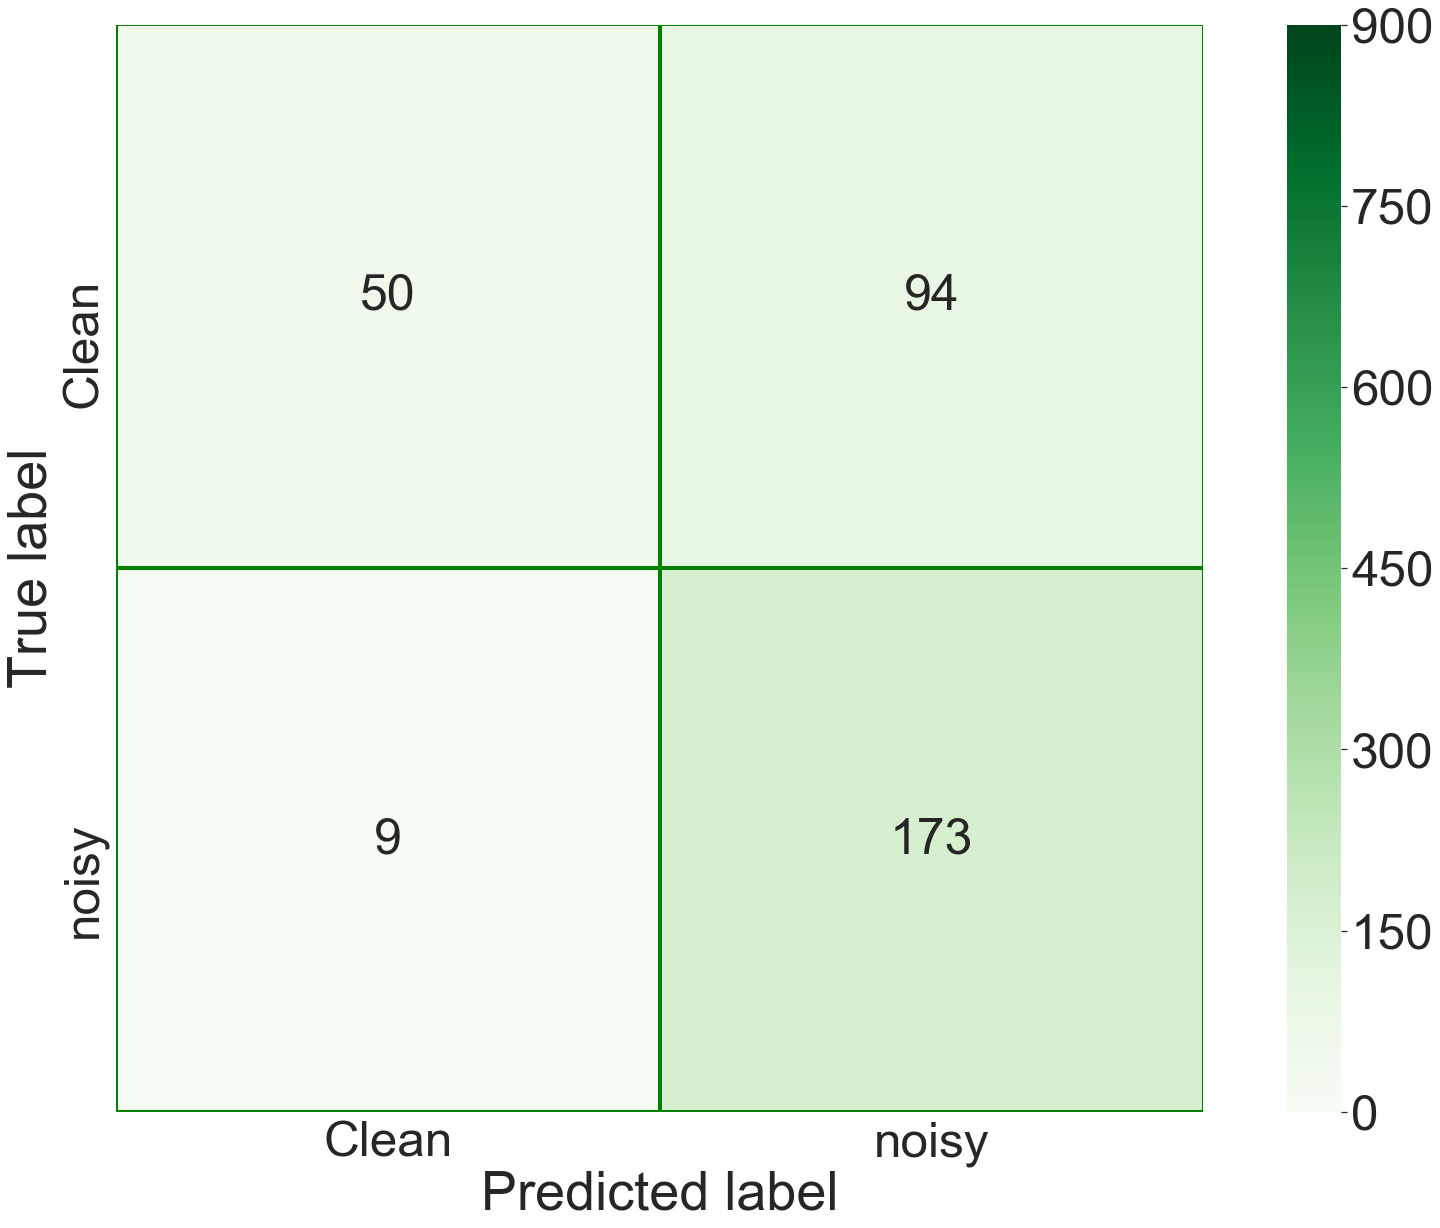

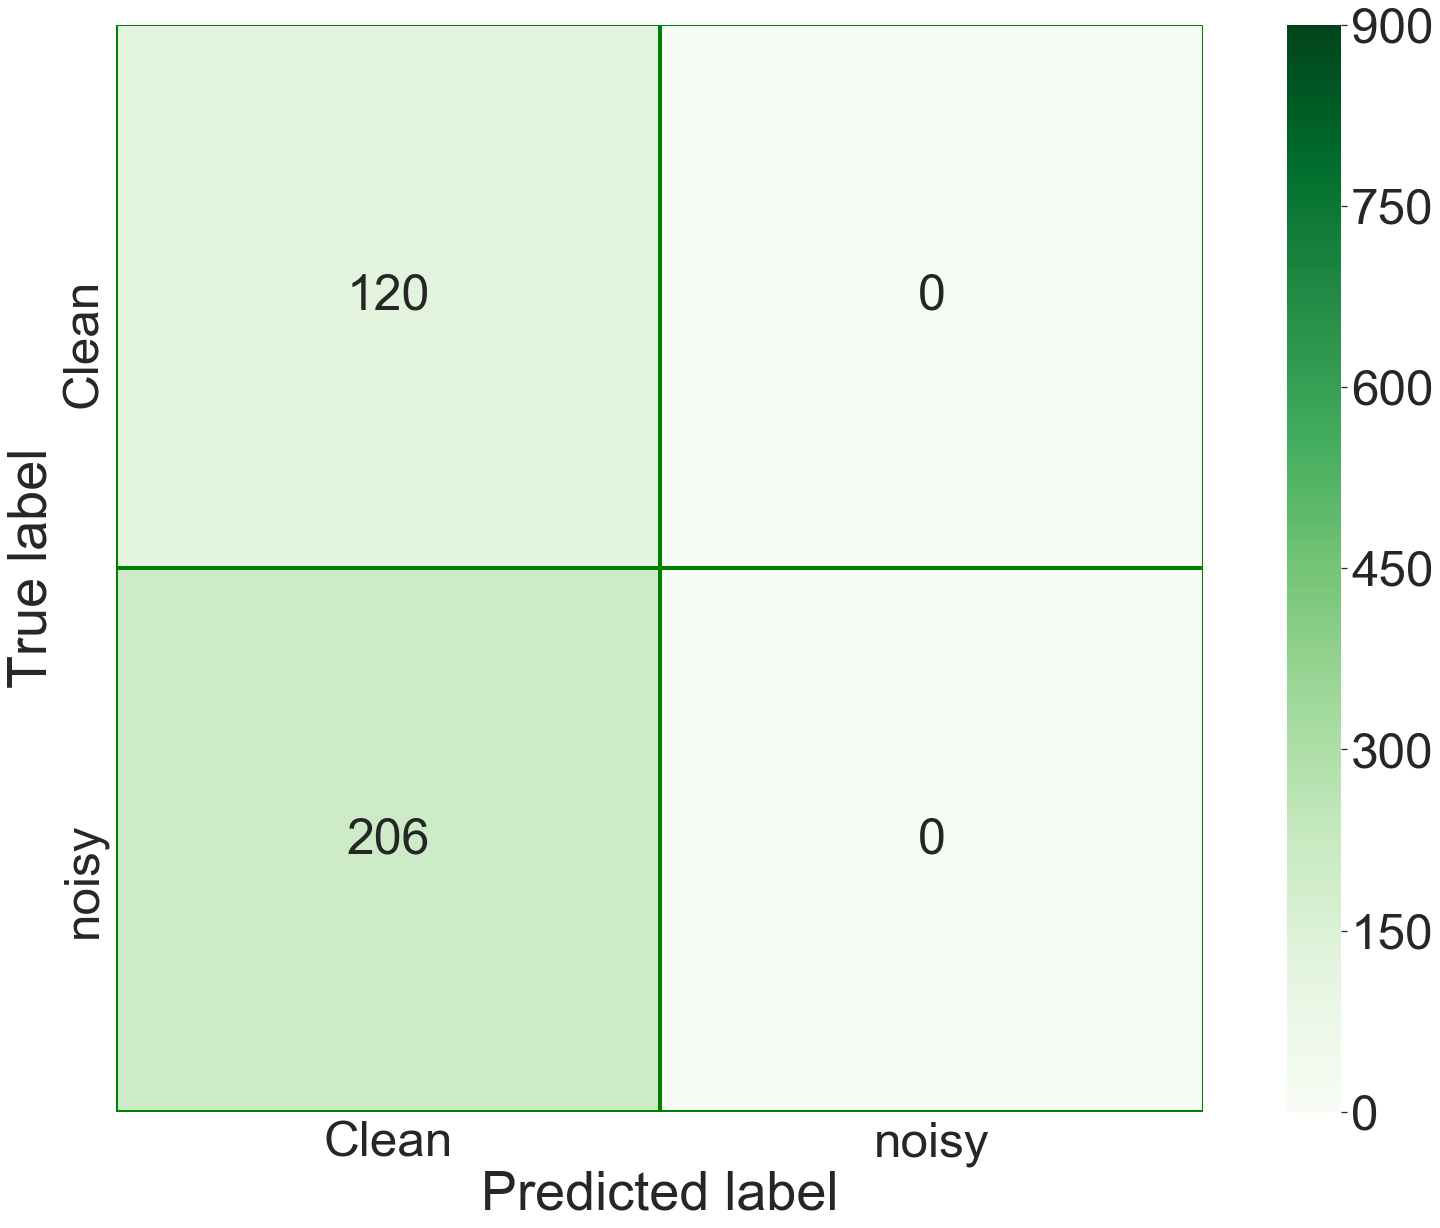

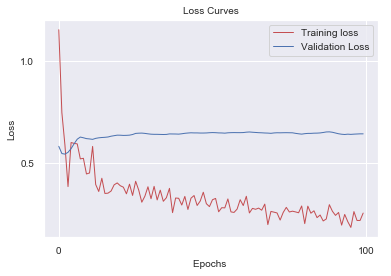

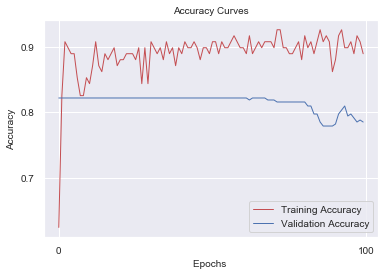

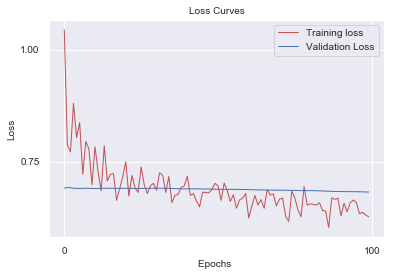

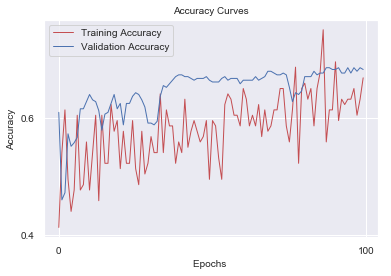

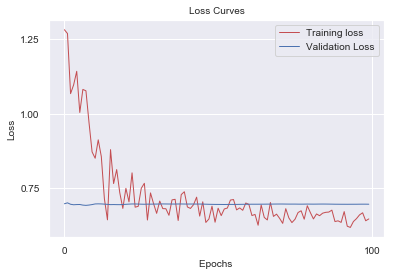

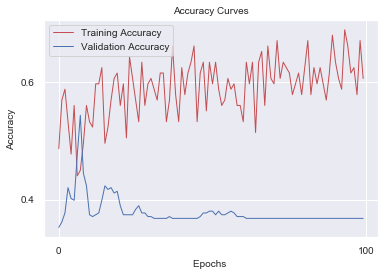

In [14]:
    ## Evaluate themodesl
    loss_cnn1, acc_cnn1 = cnn1.evaluate(test_data, testLable_cnn1, verbose=0,batch_size=batch_size)              
    loss_cnn2, acc_cnn2 = cnn2.evaluate(test_data, testLable_cnn2, verbose=0,batch_size=batch_size)  
    loss_cnn3, acc_cnn3 = cnn3.evaluate(test_data, testLable_cnn3, verbose=0,batch_size=batch_size)
    
    y_pred_cnn1 = cnn1.predict_classes(test_data)
    y_pred_cnn2 = cnn2.predict_classes(test_data)
    y_pred_cnn3 = cnn3.predict_classes(test_data)
    
    skaccuracy1 = accuracy_score(convert_to_binary(testLable_cnn1), y_pred_cnn1)
    skaccuracy2 = accuracy_score(convert_to_binary(testLable_cnn2), y_pred_cnn2)
    skaccuracy3 = accuracy_score(convert_to_binary(testLable_cnn3), y_pred_cnn3)
    print('Accuracy for CNN1, CNN2 and CNN3 are:',skaccuracy1,skaccuracy2,skaccuracy3)

    report_evalmetric(testLable_cnn1,y_pred_cnn1,output, 'augcnn1')
    report_evalmetric(testLable_cnn2,y_pred_cnn2,output, 'augcnn2')
    report_evalmetric(testLable_cnn3,y_pred_cnn3,output, 'augcnn3')

    print('Test loss and accuracy for CNN1 is:',loss_cnn1, acc_cnn1)
    print('Test loss and accuracy for CNN2 is:',loss_cnn2, acc_cnn2)
    print('Test loss and accuracy for CNN3 is:',loss_cnn3, acc_cnn3)
    
    plot_history(history_cnn1,'augcnn1', output)
    plot_history(history_cnn2,'augcnn2', output)
    plot_history(history_cnn3,'augcnn3', output)